# 1D Exchange

In [1]:
#!git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Build the system
The first step is to build the system, which will have a single nucleus, with two different chemical shifts.

In [3]:
ex0=RS.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process (symmetric exchange)
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. Here we start assuming the populations, $p_1$ and $p_2$ are equal

In [23]:
L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
    np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
L.kex=kex

## Run as a 1D Experiment
We'll start the magnetization on $S_x$ and observe $S^+$. We need a propagator from the Liouville matrix.

In [33]:
rho=RS.Rho(rho0='S0x',detect='S0p')
Dt=1/(2*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
Uevol=L.U(Dt=Dt)  #Propagator for the evolution time

_=rho.DetProp(Uevol,n=512)

## Plot the results

<IPython.core.display.Javascript object>


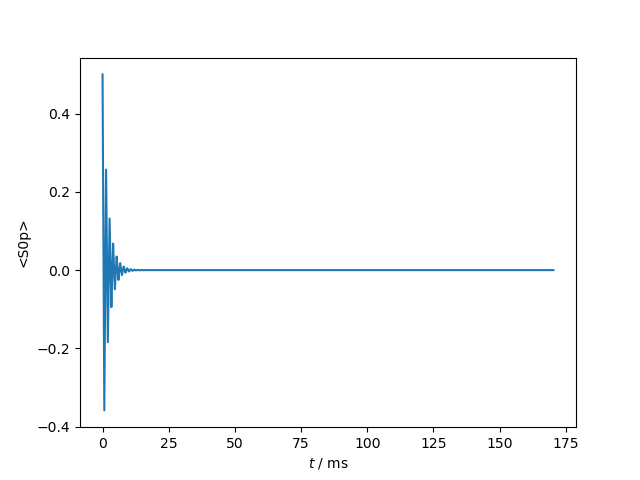

<AxesSubplot:xlabel='$t$ / ms', ylabel='<S0p>'>

In [34]:
rho.plot(FT=False,imag=False)

## Sweep through a range of correlation times to observe coalescence

In [44]:
tc0=np.logspace(-5,-2,13)[:-1]
S=list()
for tc in tc0:
    L.kex=[[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]]
    Uevol=L.U(Dt=Dt)
    rho.clear()
    rho.DetProp(Uevol,n=512)
    S.append(rho.FT[0].real)

Plot the results

<IPython.core.display.Javascript object>


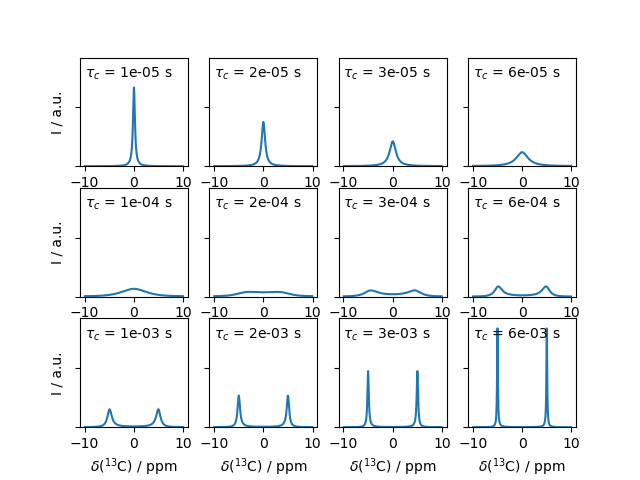

In [46]:
fig,ax=plt.subplots(3,4)
ax=ax.reshape(ax.size)
sm=0
for S0,a in zip(S,ax):
    a.plot(rho.v_axis/ex0.v0[0]*1e6,S0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_yticklabels('')
    sm=max(sm,S0.max())
for a,tc in zip(ax,tc0):
    a.set_ylim([0,sm*1.1])
    a.text(-10,sm*.9,r'$\tau_c$'+f' = {tc:.0e} s')
    

## Now we repeat, but use asymmetric exchange to see if coalescence occurs

In [47]:
p1=0.75
p2=1-p1

tc0=np.logspace(-5,-2,13)[:-1]
S=list()
for tc in tc0:
    L.kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+\
            np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])/(tc)
    Uevol=L.U(Dt=Dt)
    rho.clear()
    rho.DetProp(Uevol,n=512)
    S.append(rho.FT[0].real)

Plot the results

<IPython.core.display.Javascript object>


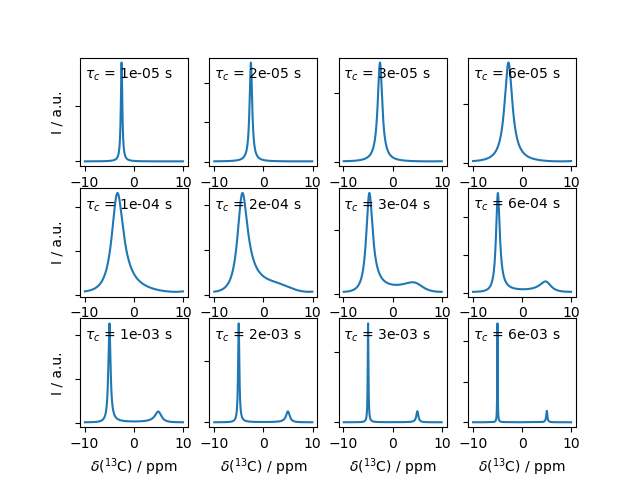

In [52]:
fig,ax=plt.subplots(3,4)
ax=ax.reshape(ax.size)
sm=0
for S0,a in zip(S,ax):
    a.plot(rho.v_axis/ex0.v0[0]*1e6,S0)
    if a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.get_subplotspec().is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_yticklabels('')
    sm=max(sm,S0.max())
for a,tc in zip(ax,tc0):
    a.text(-10,a.get_ylim()[1]*.8,r'$\tau_c$'+f' = {tc:.0e} s')